<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Imports-and-configurations" data-toc-modified-id="Imports-and-configurations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and configurations</a></span></li><li><span><a href="#Data-set-preparation:-ZEISEL" data-toc-modified-id="Data-set-preparation:-ZEISEL-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data set preparation: ZEISEL</a></span></li></ul></li><li><span><a href="#Run-models" data-toc-modified-id="Run-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run models</a></span><ul class="toc-item"><li><span><a href="#Factor-Analysis" data-toc-modified-id="Factor-Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Factor Analysis</a></span></li><li><span><a href="#ZIFA" data-toc-modified-id="ZIFA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ZIFA</a></span></li><li><span><a href="#pCMF" data-toc-modified-id="pCMF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>pCMF</a></span></li><li><span><a href="#ZINB-WaVE" data-toc-modified-id="ZINB-WaVE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>ZINB-WaVE</a></span></li><li><span><a href="#scVI" data-toc-modified-id="scVI-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>scVI</a></span></li><li><span><a href="#m-pCMF" data-toc-modified-id="m-pCMF-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>m-pCMF</a></span></li><li><span><a href="#ZINBayes" data-toc-modified-id="ZINBayes-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>ZINBayes</a></span></li></ul></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot results</a></span><ul class="toc-item"><li><span><a href="#Latent-space-clustering" data-toc-modified-id="Latent-space-clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Latent space clustering</a></span></li><li><span><a href="#Held-out-data-log-likelihood" data-toc-modified-id="Held-out-data-log-likelihood-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Held-out data log-likelihood</a></span></li><li><span><a href="#Imputation-error" data-toc-modified-id="Imputation-error-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Imputation error</a></span></li><li><span><a href="#Technical-variability" data-toc-modified-id="Technical-variability-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Technical variability</a></span></li><li><span><a href="#Gene-groups" data-toc-modified-id="Gene-groups-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Gene groups</a></span></li><li><span><a href="#Differential-Expression" data-toc-modified-id="Differential-Expression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Differential Expression</a></span></li></ul></li></ul></div>

# Initialization

## Imports and configurations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib inline

from zinbayes.zinbayes import ZINBayes

from pCMF import mpCMF

from state_of_art.scVI.scvi import scVI
from state_of_art.ZIFA.zifa import ZIFA
from state_of_art.ZINB_WaVE.zinb_wave import ZINB_WaVE
from state_of_art.pCMF.pcmf import pCMF

from misc.model_wrapper import ModelWrapper
from misc import print_utils, plot_utils

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde, pearsonr
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from edward.models import Beta, RelaxedBernoulli, Gamma, Poisson, Dirichlet, Mixture, Categorical, TransformedDistribution, Normal, PointMass

plt.style.use('seaborn-whitegrid')

In [3]:
# scatter plots style
s = 30
alpha = 0.5

## Data set preparation: ZEISEL

In [7]:
# Data retrieved from 
# https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt

data_path = '../../data/Zeisel/expression_mRNA_17-Aug-2014.txt'
X = pd.read_csv(data_path, sep='\t', low_memory=False).T

clusters = np.array(X[7], dtype=str)[2:]
precise_clusters = np.array(X[0], dtype=str)[2:]
celltypes, labels = np.unique(clusters, return_inverse=True)
_, precise_labels = np.unique(precise_clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression = np.array(X, dtype=np.int)[1:]

var_genes = np.var(expression, axis=0)
X = expression[:, np.argsort(var_genes)[-558:]]

n_cells = X.shape[0]
n_genes = X.shape[1]

print('Data shape:')
print('{} cells, {} genes\n'.format(X.shape[0], X.shape[1]))
print('{} cell types: {}\n'.format(celltypes.size, celltypes))
print('Percentage of zeros in the data set:')
print('{:.2f}%'.format(np.count_nonzero(X==0) / X.size * 100))

Data shape:
3005 cells, 558 genes

7 cell types: ['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Percentage of zeros in the data set:
29.01%


In [ ]:
X_train, X_test, c_train, c_test, = train_test_split(X, labels, test_size=0.3, shuffle=True) 

In [ ]:
N = X_train.shape[0]
N_test = X_test.shape[0]
P = n_genes
C = np.unique(labels).size

# Run models
For each model, we need:
* 5 repetitions on the full data set, for clustering benchmarking. 
    - Keep the best run and:
         - perform t-SNE;
         - get m-pCMF and ZINBayes' cell scalings.
* 5-fold cross-validation to compute the held-out data log-likelihood.
* Run on 5 different corrupted full data sets for imputation benchmarking.

(ensure scVI does not separate the data more than we want it to.)

In [5]:
K = 10

## Factor Analysis

In [ ]:
obj = FactorAnalysis(n_components=K)
fa = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='FA', do_imp=False, log_data=True)
fa.run(max_iter=1000, do_silh=True, do_dll=True, do_holl=True, do_tsne=False, verbose=True)

In [ ]:
# 5 repetitions on the full data set
fa_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = FactorAnalysis(n_components=K)
    fa = ModelWrapper(obj, X, c_train=labels, name='FA', do_imp=False, log_data=True)
    fa.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    fa_full_reps.append(fa)
    print('Done.\n')

In [ ]:
# 5-fold cross-validation 
fa_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    Y_train = X[train_idx]
    c_train = labels[train_idx]
    Y_test = X[test_idx]

    obj = FactorAnalysis(n_components=K)
    fa = ModelWrapper(obj, Y_train, c_train=c_train, X_test=Y_test, name='FA', log_data=True, do_imp=False)
    fa.run(do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    fa_cv.append(fa)
    print('Done.\n')

## ZIFA

In [ ]:
obj = ZIFA(n_components=K)
zifa = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='ZIFA', log_data=True, do_imp=False)
zifa.run(max_iter=1000, do_silh=True, do_dll=True, do_holl=True, do_tsne=False, verbose=True)

In [ ]:
# 5 repetitions on the full data set
zifa_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X, c_train=labels, name='ZIFA', log_data=True, do_imp=False)
    zifa.run(max_iter=1000, do_silh=True, max_time=60*60, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zifa_full_reps.append(zifa)
    print('Done.\n')

In [ ]:
# 5-fold cross-validation 
zifa_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, log_data=True, name='ZIFA')
    zifa.run(max_time=60*60, max_iter=100, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    zifa_cv.append(zifa)
    print('Done.\n')

In [ ]:
# 5 corrupted data sets
zifa_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X, c_train=labels, X_test=None, log_data=True, name='ZIFA', do_imp=True)
    zifa.run(max_time=60*60, max_iter=100, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zifa_imputation.append(zifa)
    print('Done.\n')

## pCMF

In [ ]:
obj = pCMF(n_components=K)
pcmf = ModelWrapper(obj, X, c_train=labels, name='pCMF', log_data=False, do_imp=False)
pcmf.run(max_iter=100, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)

In [ ]:
plt.plot(pcmf.model_inst.train_ll_it/X.shape[0])

In [ ]:
# 5 repetitions on the full data set
pcmf_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = pCMF(n_components=K)
    pcmf = ModelWrapper(obj, X, c_train=labels, name='pCMF', log_data=False, do_imp=False)
    pcmf.run(max_iter=500, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    pcmf_full_reps.append(pcmf)
    print('Done.\n')

In [ ]:
# 5 repetitions on the full data set
pcmf_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = pCMF(n_components=K)
    pcmf = ModelWrapper(obj, X, c_train=labels, name='pCMF', log_data=False, do_imp=True)
    pcmf.run(max_iter=500, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    pcmf_imputation.append(pcmf)
    print('Done.\n')

In [ ]:
pcmf_imputation[0].dropimp_err

## ZINB-WaVE

In [ ]:
obj = ZINB_WaVE(n_components=K)
zinbwave = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='ZINB-WaVE', log_data=False, do_imp=False)
zinbwave.run(max_iter=1000, do_silh=True, do_dll=True, do_holl=True, do_tsne=False, verbose=True)

In [ ]:
# 5 repetitions on the full data set
zinbwave_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X, c_train=labels, name='ZINB-WaVE', log_data=False, do_imp=False)
    zinbwave.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbwave_full_reps.append(zinbwave)
    print('Done.\n')

In [ ]:
# 5-fold cross-validation 
zinbwave_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='ZINB-WaVE', log_data=False, do_imp=False)
    zinbwave.run(do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    zinbwave_cv.append(zinbwave)
    print('Done.\n')

In [ ]:
# 5 repetitions on the full data set
zinbwave_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X, c_train=labels, X_test=None, name='ZINB-WaVE', log_data=False, do_imp=True)
    zinbwave.run(max_iter=1000, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbwave_imputation.append(zinbwave)
    print('Done.\n')

## scVI

In [ ]:
obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128, validation=True, X_test=X_test)
scvi = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='scVI', do_imp=False)
scvi.run(max_iter=1000, do_silh=True, max_time=60*5, do_dll=True, do_holl=True, do_tsne=False, verbose=True)

In [ ]:
plt.plot(scvi.model_inst.result['t_loss'][:250])
plt.plot(scvi.model_inst.result['v_loss'][:250])

In [ ]:
scvi.asw, scvi.ari, scvi.nmi, scvi.train_ll, scvi.test_ll

In [ ]:
# 5 repetitions on the full data set
scvi_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128)
    scvi = ModelWrapper(obj, X, c_train=labels, name='scVI', do_imp=False)
    scvi.run(max_iter=250, max_time=60*60, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    scvi_full_reps.append(scvi)
    print('Done.\n')

In [ ]:
# 5-fold cross-validation 
scvi_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    obj = scVI(n_components=K, n_hidden=128, batch_size=128)
    scvi = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='scVI')
    scvi.run(max_iter=250, max_time=60*60, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    scvi_cv.append(scvi)
    print('Done.\n')

In [ ]:
# 5 corrupted data sets
scvi_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128)
    scvi = ModelWrapper(obj, X, c_train=labels, X_test=None, name='scVI', do_imp=True)
    scvi.run(max_iter=250, max_time=60*60, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    scvi_imputation.append(scvi)
    print('Done.\n')

## m-pCMF

In [ ]:
np.sum(X_train, axis=1).max() / np.sum(X_train, axis=1).min()

In [ ]:
# 5-fold cross-validation 
mpcmf_poi_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    mpcmf = mpCMF(X_train, Y_test=X_test, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=False)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=False, do_holl=True, do_dll=True, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_poi_cv.append(mpcmf)
    print('Done.\n')

In [10]:
mpcmf = mpCMF(X, c_train=labels, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, calc_test=False, verbose=True)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 123/1000. ELBO: -1798.7259679. Improvement: 0.0000496. Elapsed: 0h5m36s
Convergence criterion reached.

Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
x = np.linspace(0, 100, num=100)
plt.plot(x, mpcmf.inf.elbo_it, 'k-')
# pl.fill_between(x, y-error, y+error)

In [ ]:
mpcmf.dropimp_err

In [ ]:
mpcmf.asw, mpcmf.ari, mpcmf.nmi

In [ ]:
mpcmf.test_ll

In [ ]:
plt.plot(mpcmf.inf.silh_it)

In [ ]:
plt.plot(mpcmf.inf.elbo_it)

In [ ]:
# 5 repetitions on the full data set
mpcmf_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, c_train=labels, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_full_reps.append(mpcmf)
    print('Done.\n')

In [ ]:
# 5-fold cross-validation 
mpcmf_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    mpcmf = mpCMF(X_train, Y_test=X_test, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=False, do_holl=True, do_dll=True, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_cv.append(mpcmf)
    print('Done.\n')

In [ ]:
# 5 corrupted data sets
mpcmf_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=True, name="m-pCMF", minibatch_size=None, 
                  nb=True)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=False, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_imputation.append(mpcmf)
    print('Done.\n')

## ZINBayes

In [28]:
obj = ZINBayes(n_components=K, n_mc_samples=5, test_iterations=500)
zinbayes = ModelWrapper(obj, X, c_train=labels, name='ZINBayes', do_imp=False)
zinbayes.run(max_iter=500, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)

Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 685s | Loss: 1306.187
Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [29]:
zinbayes.asw, zinbayes.ari, zinbayes.nmi

(0.3063508, 0.6363616927082137, 0.7170680553575632)

In [ ]:
zinbayes.train_ll, zinbayes.test_ll

In [ ]:
plt.plot(zinbayes.model_inst.loss_dict['t_loss'])

In [ ]:
# 5 repetitions on the full data set
zinbayes_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, n_mc_samples=5, test_iterations=500)
    zinbayes = ModelWrapper(obj, X, c_train=labels, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbayes_full_reps.append(zinbayes)
    print('Done.\n')

In [ ]:
# 5-fold cross-validation 
zinbayes_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    obj = ZINBayes(n_components=K, n_mc_samples=5, test_iterations=500)
    zinbayes = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    zinbayes_cv.append(zinbayes)
    print('Done.\n')

In [ ]:
# 5 repetitions on the full data set
zinbayes_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, n_mc_samples=5, test_iterations=500)
    zinbayes = ModelWrapper(obj, X, c_train=c_train, X_test=X_test, name='ZINBayes', do_imp=True)
    zinbayes.run(max_iter=1000, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbayes_imputation.append(zinbayes)
    print('Done.\n')

In [ ]:
obj = ZINBayes(n_components=K, n_mc_samples=1)
zinbayes = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='ZINBayes', do_imp=False)
zinbayes.run(max_iter=1000, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True)

In [ ]:
zinbayes.asw, zinbayes.ari, zinbayes.nmi

In [ ]:
zinbayes.model_inst.loss[-1] / X_train.shape[0]

In [ ]:
zinbayes.model_inst.evaluate_loglikelihood(X_test, n_iter=500)

# Plot results

In [ ]:
colors = sns.color_palette("Set1", 10, desat=.7) # this is a list of 10 colors

# We must choose what color to assign to each model
model_list_clustering = [mpcmf_full_reps, zinbayes_full_reps, zinbwave_full_reps, scvi_full_reps, pcmf_full_reps, zifa_full_reps, fa_full_reps]
model_list_ll = [mpcmf_cv, zinbayes_cv, zinbwave_cv, scvi_cv, zifa_cv, fa_cv]
model_list_imp = [mpcmf_imputation, zinbayes_imputation, zinbwave_imputation, scvi_imputation, pcmf_imputation, zifa_imputation]

# Colors
color_list_clustering = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5], colors[6]]
hatch_list_clustering = ['//', '//', None, None, None, None, None]
color_list_ll = [colors[0], colors[1], colors[2], colors[4], colors[5], colors[6]]
hatch_list_ll = ['//', '//', None, None, None, None]
color_list_imp = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5]]
hatch_list_imp = ['//', '//', None, None, None, None, None]

## Latent space clustering

In [30]:
mpcmf.do_tsne()
zinbayes.do_tsne()
model_list_2d = [mpcmf, zinbayes]

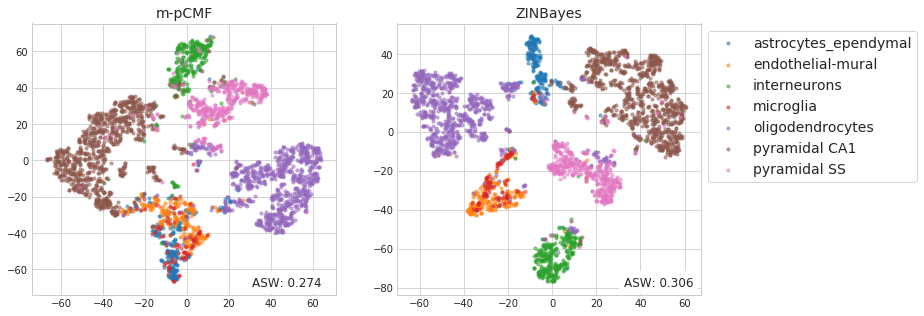

In [38]:
fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 2, 1)
plot_utils.plot_tsne(model_list_2d[0].proj_2d, labels, ax=ax, title=model_list_2d[0].name, s=10)
plt.figtext(0.38, .15, 'ASW: {:.3f}'.format(mpcmf.asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(1, 2, 2)
plot_utils.plot_tsne(model_list_2d[1].proj_2d, labels, ax=ax, title=model_list_2d[1].name, s=10, legend=True, labels=clusters, ncol=1)
plt.figtext(0.81, .15, 'ASW: {:.3f}'.format(model_list_2d[1].asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.savefig('ZEISEL_2d_mpcmf_zinbayes.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax  = plot_utils.clustering_cv(model_list_clustering, colors=color_list_clustering, show_legend=True, ylim=[-0.1, 1],
                            title=None, ax=ax, box=False, hatches=None);
ax.figure.savefig('ZEISEL_clustering_bars_legend.png', dpi=300, bbox_inches='tight')

In [ ]:
mpcmf_full_reps[0].ari

In [ ]:
model_list_2d = [mpcmf_full_reps[0], zinbayes_full_reps[0], zinbwave_full_reps[0], scvi_full_reps[0], 
                 pcmf_full_reps[0], zifa_full_reps[0], fa_full_reps[0]]

In [ ]:
for model in model_list_2d:
    model.do_tsne()

In [ ]:
fig = plt.figure(figsize=(17, 8))
ax = plt.axes()
plot_utils.plot_2d(model_list_2d, labels, nrows=2, ncols=4, ax=ax, 
                          labels=clusters, legend=True, bbox_to_anchor=[1.2, 1.], titles=True, filename='ZEISEL_2d_all.png')

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
plot_utils.plot_2d([model_list_2d[1]], labels, nrows=1, ncols=1, ax=ax, 
                          labels=clusters, legend=True, bbox_to_anchor=[1., 1.], titles=True, filename='ZEISEL_2d_ZINBayes.png')

## Held-out data log-likelihood

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax = plot_utils.loglikelihood_cv(model_list_ll, colors=color_list_ll, show_legend=True, hatches=None,
                            title=None, ax=ax, box=False);
ax.figure.savefig('ZEISEL_ll_legend.png', dpi=300, bbox_inches='tight')

## Imputation error

In [ ]:
plt.figure(figsize=(5, 6))
ax = plt.axes()
ax, _, _ = plot_utils.imputationerr_boxplot(model_list_imp, colors=color_list_imp, 
                                 show_legend=False, ax=ax, box=False, hatches=None);
ax.figure.savefig('ZEISEL_imp.png', dpi=300, bbox_inches='tight')

## Technical variability

In [ ]:
log_library_size = np.log(np.sum(X, axis=1))

In [ ]:
from scipy.stats import pearsonr

In [ ]:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot(1, 2, 1)
est_l = mpcmf_full_reps[1].est_L
plt.scatter(np.log(est_l.ravel()), log_library_size, alpha=0.5, s=30)
plt.ylabel('log library size', fontsize=14)
plt.xlabel('log cell scaling', fontsize=14)
plt.title('m-pCMF (corr={:.4f})'.format(pearsonr(np.log(est_l).ravel(), log_library_size.ravel())[0]), fontsize=14)
# plt.xlim(log_library_size.min(), log_library_size.max())

ax = plt.subplot(1, 2, 2, sharey=ax)
est_l = zinbayes_full_reps[1].model_inst.est_L
plt.scatter(np.log(est_l.ravel()), log_library_size, alpha=0.5, s=30)
# plt.ylabel('log-library size')
plt.xlabel('log cell scaling', fontsize=14)
plt.title('ZINBayes (corr={:.4f})'.format(pearsonr(np.log(est_l).ravel(), log_library_size.ravel())[0]), fontsize=14)
# plt.xlim(log_library_size.min(), log_library_size.max())

# ax = plt.subplot(1, 3, 3, sharey=ax)
# est_l = scvi_full_reps[1].model_inst.est_L
# plt.scatter(est_l.ravel(), log_library_size, alpha=0.5, s=30)
# # plt.ylabel('log-library size')
# plt.xlabel('log cell scaling', fontsize=14)
# plt.title('scVI (corr={:.4f})'.format(pearsonr(np.log(est_l).ravel(), log_library_size.ravel())[0]), fontsize=14)
# plt.xlim(log_library_size.min(), log_library_size.max())
fig.savefig('ZEISEL_scalings.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [ ]:
est_pi = np.mean(sigmoid(np.matmul(zinbayes_full_reps[3].model_inst.est_Z, zinbayes.model_inst.est_W1)), axis=1)
est_nb_mean = np.copy(zinbayes_full_reps[3].model_inst.est_X)
est_r = zinbayes_full_reps[3].model_inst.est_r

# est_zero_prob_zinb = np.mean(est_pi, axis=0) + np.mean(1. - est_pi, axis=0) * (est_r/(est_nb_mean + est_r))**est_r
est_zero_prob_nb = (est_r/(est_nb_mean + est_r))**est_r

In [ ]:
mean_est_zero_prob_nb = np.mean(est_zero_prob_nb, axis=1)
zero_prop = np.sum(X==0, axis=1) / X.shape[1]

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.scatter(mean_est_zero_prob_nb, zero_prop, alpha=0.5)
plt.ylabel('Proportion of zeros in each cell', fontsize=14)
plt.xlabel('Zero probability from Negative Binomial', fontsize=14)
fig.savefig('zinbayes_nb_zeros.png', dpi=300, bbox_inches='tight')

In [ ]:
mean_est_zero_prob_ber = np.mean(est_pi, axis=0)
fig = plt.figure(figsize=(6, 5))
plt.scatter(est_pi, zero_prop, alpha=0.5)
plt.ylabel('Proportion of zeros in each cell', fontsize=14)
plt.xlabel('Zero probability from Bernoulli', fontsize=14)
fig.savefig('zinbayes_nb_zeros.png', dpi=300, bbox_inches='tight')

In [ ]:
# DETECTION RATE: the proportion of genes in a cell reporting the expression levels 
# greater than a predetermined threshold delta
delta = 0
detection_rate = np.sum(X > delta, axis=1) / X.shape[1]

# LIBRARY SIZE: number of molecules detected in a cell
library_size = np.sum(X, axis=1)

In [ ]:
pearsonr(detection_rate, library_size)

In [ ]:
plt.scatter(detection_rate, zero_prop)
plt.show()

In [ ]:
est_l = zinbayes_full_reps[1].model_inst.est_L
plt.scatter(detection_rate, est_l.ravel(), alpha=0.5, s=30)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
fa_2d = PCA(n_components=K).fit_transform(X)
print(pearsonr(fa_2d[:, 0], library_size)[0])
print(pearsonr(fa_2d[:, 1], library_size)[0])
print(pearsonr(fa_2d[:, 0], detection_rate)[0])
print(pearsonr(fa_2d[:, 1], detection_rate)[0])

## Gene groups

In [ ]:
pearsonr(np.log(est_l).ravel(), log_library_size.ravel())

## Differential Expression